In [1]:
import uuid
import random
import pandas as pd
import numpy as np
from scipy.stats import entropy
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
# generate data
def generate_data(n):
    """
    This function will generate n rows of sample data.
    
    params:
        n (Int) : The number of rows you want to generate
        
    returns:
        A pandas dataframe with n rows.
    """
    data = {
        'uuid' : [str(uuid.uuid4()) for _ in range(n)],
        'feature1' : [random.random() for _ in range(n)],
        'feature2' : [random.random() for _ in range(n)],
        'feature3' : [random.random() for _ in range(n)],
        'target' : [sum([random.random(), random.random(), random.random()]) for _ in range(n)]
    }
    return pd.DataFrame(data)

sample_df = generate_data(1000)
sample_df.head()

,uuid,feature1,feature2,feature3,target
0,47be8726-3373-4c5f-90e3-a0c985e8c2fa,0.940277,0.293241,0.887842,1.214733
1,05540521-19a9-463f-9997-d7c4f600ddba,0.755155,0.790025,0.207441,2.643144
2,88167dee-f562-470a-a41b-cc4625c938b7,0.770674,0.532005,0.013269,1.032481
3,1325d84c-6bae-454b-ab0a-fda307741d44,0.594305,0.480034,0.404041,1.685098
4,ed465004-5869-431b-bd3e-0c8b14974703,0.115499,0.111589,0.045613,1.463835


In [3]:
# train model
ft_cols = ['feature1', 'feature2', 'feature3']
X = sample_df[ft_cols].values
Y = sample_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3
)

rfr = RandomForestRegressor().fit(X_train, y_train)

In [4]:
# generate observations
obs_df = generate_data(1500)
obs_df.drop(columns = ['target'], inplace = True)

In [5]:
obs_df['prediction'] = obs_df[ft_cols].apply(lambda x : rfr.predict([x])[0], axis = 1)

In [6]:
obs_df = obs_df.rename(columns = {
    'feature1' : 'obs_feature1',
    'feature2' : 'obs_feature2',
    'feature3' : 'obs_feature3'
})

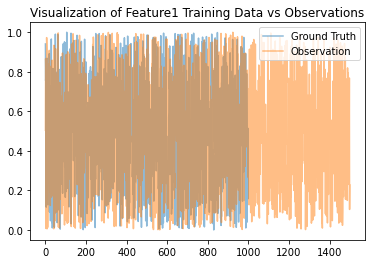

In [7]:
plt.plot(sample_df['feature1'], alpha = 0.5, label = 'Ground Truth')
plt.plot(obs_df['obs_feature1'], alpha = 0.5, label = 'Observation')
plt.legend()
plt.title("Visualization of Feature1 Training Data vs Observations")
plt.show()

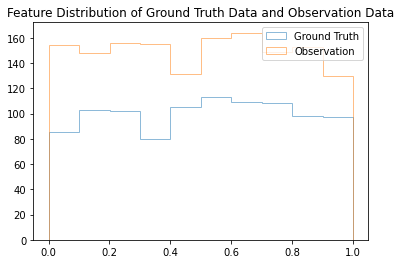

In [8]:
plt.hist(sample_df['feature1'], alpha = 0.5, label = 'Ground Truth', histtype = 'step')
plt.hist(obs_df['obs_feature1'], alpha = 0.5, label = 'Observation', histtype = 'step')
plt.legend()
plt.title("Feature Distribution of Ground Truth Data and Observation Data")
plt.show()

In [9]:
def data_length_normalizer(gt_data, obs_data, bins = 100):
    """
    Data length normalizer will normalize a set of data points if they
    are not the same length.
    
    params:
        gt_data (List) : The list of values associated with the training data
        obs_data (List) : The list of values associated with the observations
        bins (Int) : The number of bins you want to use for the distributions
        
    returns:
        The ground truth and observation data in the same length.
    """

    if len(gt_data) == len(obs_data):
        return gt_data, obs_data 

    # scale bins accordingly to data size
    if (len(gt_data) > 20*bins) and (len(obs_data) > 20*bins):
        bins = 10*bins 

    # convert into frequency based distributions
    gt_hist = plt.hist(gt_data, bins = bins)[0]
    obs_hist = plt.hist(obs_data, bins = bins)[0]
    plt.close()  # prevents plot from showing
    return gt_hist, obs_hist 

def softmax(vec):
    """
    This function will calculate the softmax of an array, essentially it will
    convert an array of values into an array of probabilities.
    
    params:
        vec (List) : A list of values you want to calculate the softmax for
        
    returns:
        A list of probabilities associated with the input vector
    """
    return(np.exp(vec)/np.exp(vec).sum())

def calc_cross_entropy(p, q):
    """
    This function will calculate the cross entropy for a pair of 
    distributions.
    
    params:
        p (List) : A discrete distribution of values
        q (List) : Sequence against which the relative entropy is computed.
        
    returns:
        The calculated entropy
    """
    return entropy(p,q)

In [10]:
def calc_drift(gt_data, obs_data, gt_col, obs_col):
    """
    This function will calculate the drift of two distributions given
    the drift type identifeid by the user.
    
    params:
        gt_data (DataFrame) : The dataset which holds the training information
        obs_data (DataFrame) : The dataset which holds the observed information
        gt_col (String) : The training data column you want to compare
        obs_col (String) : The observation column you want to compare
        
    returns:
        A drift score
    """

    gt_data = gt_data[gt_col].values
    obs_data = obs_data[obs_col].values

    # makes sure the data is same size
    gt_data, obs_data = data_length_normalizer(
        gt_data = gt_data,
        obs_data = obs_data
    )

    # convert to probabilities
    gt_data = softmax(gt_data)
    obs_data = softmax(obs_data)

    # run drift scores
    drift_score = calc_cross_entropy(gt_data, obs_data)
    return drift_score

In [11]:
calc_drift(
    gt_data = sample_df, 
    obs_data = obs_df, 
    gt_col = 'feature1', 
    obs_col = 'obs_feature1'
)

7.942241086128684

In [12]:
drift_scores = {k:[] for k in ft_cols}
days = 5
for i in range(days):
    # calculate drift for all features and store results
    for i in ft_cols:
        drift = calc_drift(
            gt_data = sample_df, 
            obs_data = generate_data(1500), 
            gt_col = 'feature1', 
            obs_col = 'feature1'
        )
        drift_scores[i].append(drift)

In [13]:
drift_df = pd.DataFrame(drift_scores)

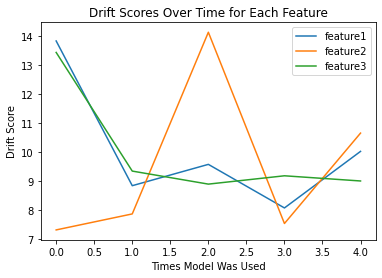

In [14]:
drift_df.plot(kind = 'line')
plt.title("Drift Scores Over Time for Each Feature")
plt.ylabel("Drift Score")
plt.xlabel("Times Model Was Used")
plt.show()